In [11]:
# TEST GPU
import torch


print('Cuda availability :',torch.cuda.is_available())
print('How many cuda device :', torch.cuda.device_count())
cuda_device = torch.cuda.current_device()
print('Name of current device :',torch.cuda.get_device_name(cuda_device))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

Cuda availability : True
How many cuda device : 1
Name of current device : NVIDIA GeForce RTX 3090


In [12]:
# pass data to device
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield  to_device(b, self.device)

    def __len__(self):
        """number of batches"""
        return len(self.dl)

In [14]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [15]:
PROJECT_NAME = '05-cifar10-cnn'

In [16]:
DATASET_URL = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(DATASET_URL, '.')




Using downloaded and verified file: ./cifar10.tgz


In [17]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [20]:
DATA_DIR = './data/cifar10'

print(os.listdir(DATA_DIR))
classes = os.listdir(DATA_DIR + "/train")
print(classes)

['test', 'train']
['frog', 'ship', 'dog', 'deer', 'bird', 'truck', 'airplane', 'automobile', 'cat', 'horse']


In [22]:
airplane_files = os.listdir(DATA_DIR+ "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])


No. of training examples for airplanes: 5000
['1687.png', '3071.png', '2442.png', '3856.png', '4900.png']


In [23]:
ship_test_files = os.listdir(DATA_DIR+"/test/ship")
print('No. of test examples for ships:', len(ship_test_files))
print(ship_test_files[:5])


No. of test examples for ships: 1000
['0201.png', '0531.png', '0082.png', '0618.png', '0536.png']


In [25]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [29]:
dataset = ImageFolder(DATA_DIR + "/train", transform=ToTensor())


In [30]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [31]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [33]:
def show_example(img, label):
    print('Label:', dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1,2,0))

Label: airplane (0)


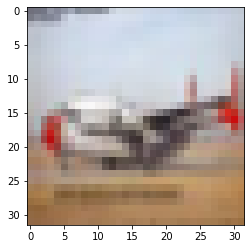

In [36]:
show_example(*dataset[1099])

In [37]:
RANDOM_SEED = 22
torch.manual_seed(RANDOM_SEED)

In [38]:
VAL_SIZE = 5000
TRAIN_SIZE = len(dataset) - VAL_SIZE

train_ds, val_ds = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])
len(train_ds), len(val_ds)

(45000, 5000)

In [39]:
from torch.utils.data.dataloader import  DataLoader

BATCH_SIZE = 128

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)

val_dl = DataLoader(val_ds, BATCH_SIZE*2, num_workers=4, pin_memory=True)
val_dl = DeviceDataLoader(val_dl, device)

In [50]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])

        images = images.cpu()
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

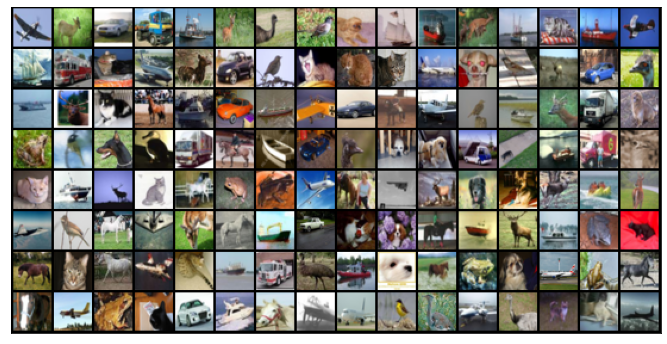

In [98]:
show_batch(train_dl)

## Kernel of convolution

![](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

In [99]:
def apply_kernel(image, kernel):
    row_image, col_image = image.shape
    row_kernel, col_kernel = kernel.shape
    row_output, col_output = row_image-row_kernel+1, col_image-col_kernel+1
    output = torch.zeros([row_output, col_output])
    for i in range(row_output):
        for j  in range(col_output):
            output[i,j] = torch.sum(image[i: i+row_kernel, j:j+col_kernel] * kernel)

    return output



In [100]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images
different kernel is applied to each channels

In [101]:
import torch.nn as nn
import torch.nn.functional as F

simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [102]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images.cpu())
    print('out.shape:', out.shape)

    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [103]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']
        ))

In [104]:
class Cifar10CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128x8x8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256x4x4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)

In [109]:
model = Cifar10CNNModel()
model
to_device(model, device)



Cifar10CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [110]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape', out.shape)
    print('out[0]:', out[0])
    break


images.shape: torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 10])
out[0]: tensor([ 0.0403, -0.0310, -0.0503,  0.0323, -0.0309,  0.0171, -0.0233, -0.0355,
         0.0412, -0.0123], device='cuda:0', grad_fn=<SelectBackward>)


In [112]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history



In [113]:
evaluate(model, val_dl)

{'val_loss': 2.3037590980529785, 'val_acc': 0.09618566185235977}

In [121]:
num_epochs  = 30
opt_func = torch.optim.Adam
lr = 0.001


In [122]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.2990, val_loss: 0.8531, val_acc: 0.7638
Epoch [1], train_loss: 0.2283, val_loss: 0.8816, val_acc: 0.7582
Epoch [2], train_loss: 0.1957, val_loss: 0.9608, val_acc: 0.7597
Epoch [3], train_loss: 0.1601, val_loss: 1.2046, val_acc: 0.7406
Epoch [4], train_loss: 0.1489, val_loss: 1.0610, val_acc: 0.7650
Epoch [5], train_loss: 0.1326, val_loss: 1.2427, val_acc: 0.7457
Epoch [6], train_loss: 0.1119, val_loss: 1.2709, val_acc: 0.7546
Epoch [7], train_loss: 0.1052, val_loss: 1.3902, val_acc: 0.7514
Epoch [8], train_loss: 0.0976, val_loss: 1.4232, val_acc: 0.7488
Epoch [9], train_loss: 0.0845, val_loss: 1.3487, val_acc: 0.7508
Epoch [10], train_loss: 0.0942, val_loss: 1.4223, val_acc: 0.7525
Epoch [11], train_loss: 0.0873, val_loss: 1.4681, val_acc: 0.7479
Epoch [12], train_loss: 0.0731, val_loss: 1.4569, val_acc: 0.7514
Epoch [13], train_loss: 0.0685, val_loss: 1.5835, val_acc: 0.7547
Epoch [14], train_loss: 0.0770, val_loss: 1.4541, val_acc: 0.7564
Epoch [15], train_lo

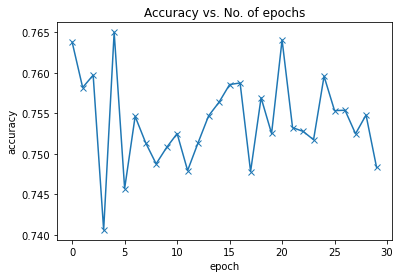

In [123]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

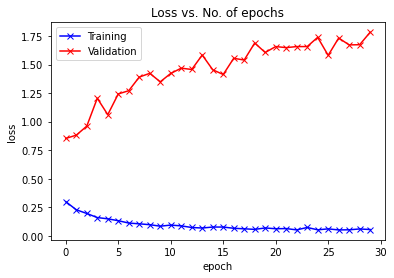

In [124]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]

    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)